# Scripts iniciais para gerar mapa de calor

Carregando modelo 'yolov8n.pt'...
Abrindo v√≠deo: '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/videos/MOT20-01-raw.webm'...


Analisando v√≠deo: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 429/429 [00:03<00:00, 135.26it/s]


Gerando visualiza√ß√£o do mapa de calor...

‚úÖ Visualiza√ß√£o do mapa de calor salva em: /content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/resultados/mapa_de_calor_ESTATICO_FINAL.png


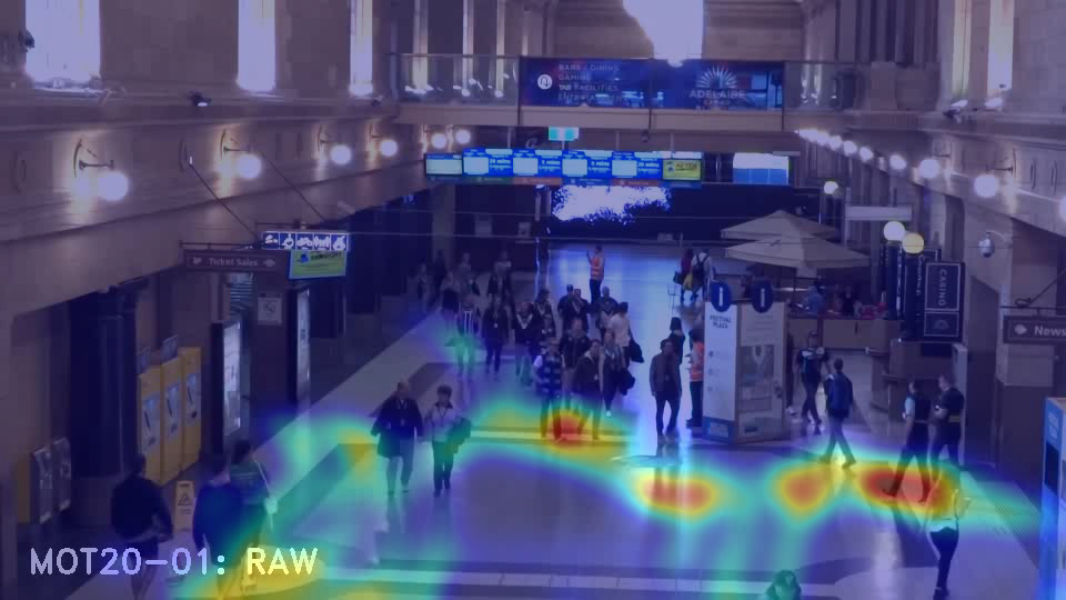


--- An√°lise Quantitativa do V√≠deo ---
Total de frames no v√≠deo: 429
Frames efetivamente analisados (considerando FRAME_SKIP=2): 143
Total de detec√ß√µes de pessoas: 1713
M√©dia de pessoas detectadas por frame analisado: 11.98
------------------------------------


In [ ]:
# ==================================================================================================
# FASE 1: GERADOR DE MAPA DE CALOR EST√ÅTICO - V1.1
# DESCRI√á√ÉO: Script otimizado para gerar uma imagem de mapa de calor de alta qualidade
#            e extrair dados quantitativos da an√°lise de um arquivo de v√≠deo.
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALA√á√ïES E IMPORTS
# --------------------------------------------------------------------------------------------------
!pip install ultralytics tqdm -q

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm # Para a barra de progresso

# --------------------------------------------------------------------------------------------------
# 2. CONFIGURA√á√ÉO CENTRALIZADA
# --------------------------------------------------------------------------------------------------
# Acesso ao Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/'
VIDEO_PATH = os.path.join(BASE_DIR, 'videos/MOT20-01-raw.webm')
RESULTS_PATH = os.path.join(BASE_DIR, 'resultados/')

# --- Configura√ß√µes do Modelo YOLO ---
# Usando o 'yolov8n.pt' √© leve, r√°pido e mais comum nas aplica√ß√µes.
MODEL_NAME = 'yolov8n.pt'
CONF_THRESHOLD = 0.4 # Limiar de confian√ßa: Apenas detec√ß√µes com score > 0.4 s√£o consideradas.

# --- Configura√ß√µes de Performance ---
# Pula N frames para acelerar. 2 significa que 1 em cada 3 frames √© analisado.
FRAME_SKIP = 2

# --- Configura√ß√µes Visuais do Mapa de Calor ---
# JUSTIFICATIVA: Um kernel grande (95,95) foi escolhido para criar manchas bem difusas,
# ideal para visualizar aglomera√ß√µes em v√≠deos de longa dist√¢ncia.
GAUSSIAN_KERNEL_SIZE = (95, 95)
# "For√ßa" de cada ponto. Um valor maior torna as √°reas de pico mais "vermelhas".
HEAT_POINT_INTENSITY = 5
# Transpar√™ncia do mapa sobre o v√≠deo.
HEATMAP_ALPHA = 0.4
COLOR_MAP = cv2.COLORMAP_JET

# --------------------------------------------------------------------------------------------------
# 3. L√ìGICA PRINCIPAL DO SCRIPT
# --------------------------------------------------------------------------------------------------

def generate_static_heatmap():
    """
    Fun√ß√£o principal que encapsula a l√≥gica para gerar o mapa de calor est√°tico.
    Ela processa um v√≠deo, coleta pontos de calor, gera uma imagem de sobreposi√ß√£o
    e imprime uma an√°lise quantitativa b√°sica dos dados.
    """
    os.makedirs(RESULTS_PATH, exist_ok=True)

    # --- Carregamento e Verifica√ß√£o ---
    print(f"Carregando modelo '{MODEL_NAME}'...")
    model = YOLO(MODEL_NAME)

    print(f"Abrindo v√≠deo: '{VIDEO_PATH}'...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("ERRO CR√çTICO: N√£o foi poss√≠vel abrir o arquivo de v√≠deo. Verifique o caminho.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # --- Coleta de Pontos de Calor ---
    heat_points = []
    background_frame_captured = False # Flag para pegar o primeiro frame
    background_frame = None
    frames_processed_count = 0

    with tqdm(total=total_frames, desc="Analisando v√≠deo") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                pbar.update(total_frames - pbar.n)
                break

            pbar.update(1)

            # MELHORIA: Pega o primeiro frame v√°lido como fundo e evita reabrir o v√≠deo
            if not background_frame_captured:
                background_frame = frame.copy()
                background_frame_captured = True

            # Pula frames conforme a configura√ß√£o
            if pbar.n % (FRAME_SKIP + 1) != 0:
                continue

            frames_processed_count += 1
            results = model(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)

            for r in results:
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    center_x, bottom_y = int((x1 + x2) / 2), int(y2)
                    heat_points.append((center_x, bottom_y))

    cap.release()

    # --- Gera√ß√£o do Mapa de Calor Visual ---
    if not background_frame_captured:
        print("ERRO: N√£o foi poss√≠vel ler nenhum frame do v√≠deo para usar como fundo.")
        return

    print("Gerando visualiza√ß√£o do mapa de calor...")
    heatmap_matrix = np.zeros((frame_height, frame_width), dtype=np.float32)
    for x, y in heat_points:
        if 0 <= y < frame_height and 0 <= x < frame_width:
            heatmap_matrix[y, x] += HEAT_POINT_INTENSITY

    heatmap_matrix = cv2.GaussianBlur(heatmap_matrix, GAUSSIAN_KERNEL_SIZE, 0)
    heatmap_normalized = cv2.normalize(heatmap_matrix, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    colored_heatmap = cv2.applyColorMap(heatmap_normalized, COLOR_MAP)
    superimposed_img = cv2.addWeighted(background_frame, 1 - HEATMAP_ALPHA, colored_heatmap, HEATMAP_ALPHA, 0)

    # --- Salvamento e Exibi√ß√£o ---
    output_path = os.path.join(RESULTS_PATH, 'mapa_de_calor_ESTATICO_FINAL.png')
    cv2.imwrite(output_path, superimposed_img)
    print(f"\n‚úÖ Visualiza√ß√£o do mapa de calor salva em: {output_path}")

    display_height = 600
    display_width = int(frame_width * (display_height / frame_height))
    display_img = cv2.resize(superimposed_img, (display_width, display_height))
    cv2_imshow(display_img)

    # --- NOVA SE√á√ÉO: An√°lise Quantitativa (A cereja do bolo) ---
    print("\n--- An√°lise Quantitativa do V√≠deo ---")
    total_detections = len(heat_points)
    avg_detections_per_frame = total_detections / frames_processed_count if frames_processed_count > 0 else 0
    print(f"Total de frames no v√≠deo: {total_frames}")
    print(f"Frames efetivamente analisados (considerando FRAME_SKIP={FRAME_SKIP}): {frames_processed_count}")
    print(f"Total de detec√ß√µes de pessoas: {total_detections}")
    print(f"M√©dia de pessoas detectadas por frame analisado: {avg_detections_per_frame:.2f}")
    print("------------------------------------")


# --------------------------------------------------------------------------------------------------
# 4. PONTO DE ENTRADA DO SCRIPT
# --------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    generate_static_heatmap()

In [ ]:
"""
Minha An√°lise sobre o C√≥digo V1.1

O que eu consegui fazer e deu certo:

Meu c√≥digo V1.1 cumpriu seu objetivo inicial: ele processa um v√≠deo e gera um mapa de calor est√°tico, al√©m de alguns dados b√°sicos. Eu me orgulho da estrutura que criei, com uma se√ß√£o de configura√ß√£o centralizada que facilitou muito os testes e ajustes. A implementa√ß√£o do FRAME_SKIP tamb√©m foi um sucesso, pois deixou o processo bem mais r√°pido. No geral, consegui criar uma base funcional e organizada.

O que eu percebi que deu errado (a limita√ß√£o principal):

Ao analisar os resultados, notei uma falha conceitual importante. Meu c√≥digo n√£o tem "mem√≥ria". Ou seja, ele detecta uma pessoa em um frame, mas no frame seguinte, n√£o sabe se √© a mesma pessoa que apenas se moveu um pouco. Para ele, cada detec√ß√£o √© um evento novo e isolado.

Isso causou dois problemas principais:

- Dados Inflados: Minha "An√°lise Quantitativa" ficou enganosa. O "Total de detec√ß√µes" que eu estava medindo n√£o era o "total de pessoas", mas sim o "total de vezes que uma pessoa foi vista". Uma √∫nica pessoa parada por 10 frames era contada 10 vezes.

- Mapa de Calor Impreciso: O mapa de calor acabou mostrando mais o "tr√°fego" (onde houve mais movimento) do que a "ocupa√ß√£o" real (onde as pessoas passaram mais tempo).

Conclus√£o e Pr√≥ximo Passo:

O "erro" do meu c√≥digo V1.1 n√£o foi um bug, mas a descoberta de que eu preciso de uma abordagem mais inteligente para atingir a precis√£o que o trabalho exige.

Para resolver isso, percebi que meu sistema precisa ser capaz de identificar e seguir indiv√≠duos ao longo do tempo. Por isso, meu pr√≥ximo passo √© testar o c√≥digo V2.0, que implementa o rastreamento de objetos (SORT). Ele vai me dar os IDs √∫nicos de cada pessoa, corrigindo a contagem e fazendo com que o mapa de calor represente fielmente onde as pessoas realmente estiveram.

"""

Carregando modelo 'yolov8n.pt'...
Abrindo v√≠deo: '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/videos/MOT20-01-raw.webm'...


Analisando v√≠deo: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 429/429 [00:03<00:00, 130.74it/s]



‚úÖ Mapa de calor com rastreamento salvo em: /content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/resultados/mapa_de_calor_COM_RASTREAMENTO_E_PLOTS.png


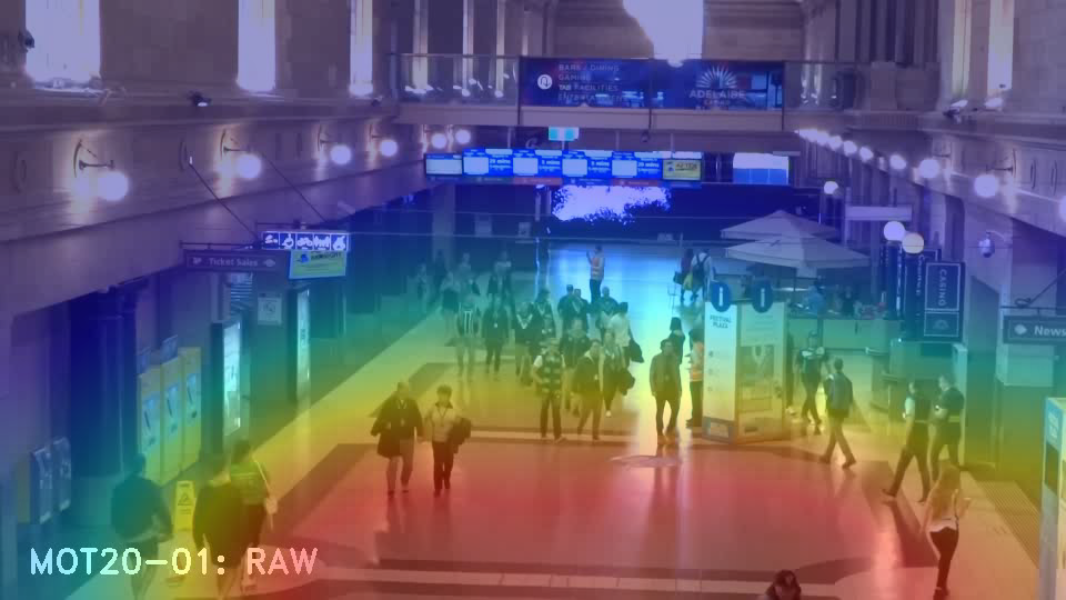


üìä Gerando visualiza√ß√µes gr√°ficas...


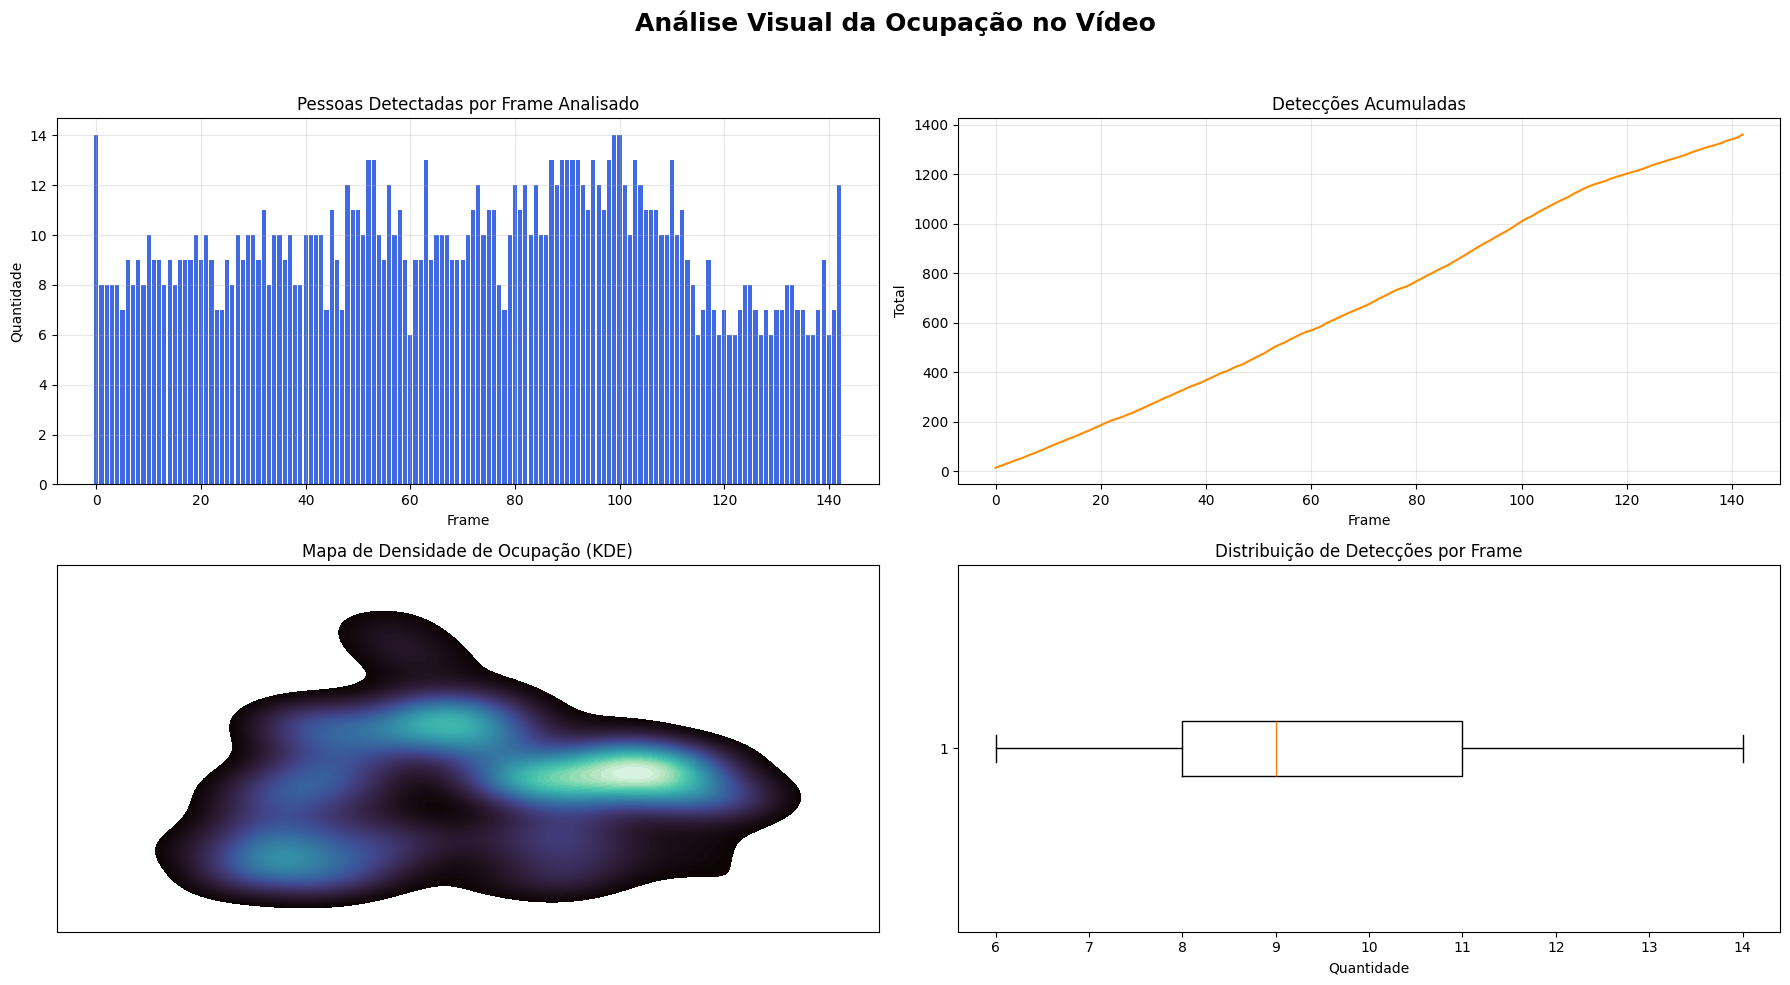


--- An√°lise Quantitativa Final ---
Total de frames no v√≠deo: 429
Frames analisados: 143
Pessoas √∫nicas rastreadas (IDs distintos): 208
Detec√ß√µes totais (todas as apari√ß√µes): 1361
M√©dia de detec√ß√µes por frame: 9.52
Mediana: 9.00
Desvio padr√£o: 2.06
-------------------------------------------------------------


In [ ]:
# ==================================================================================================
# FASE 2.1 ‚Äî VISUALIZA√á√ÉO COM RASTREAMENTO E AN√ÅLISE GR√ÅFICA
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALA√á√ïES E IMPORTS
# --------------------------------------------------------------------------------------------------
!pip install ultralytics tqdm filterpy matplotlib seaborn -q

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from filterpy.kalman import KalmanFilter
from collections import deque

# --------------------------------------------------------------------------------------------------
# 2. CONFIGURA√á√ïES
# --------------------------------------------------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/'
VIDEO_PATH = os.path.join(BASE_DIR, 'videos/MOT20-01-raw.webm')
RESULTS_PATH = os.path.join(BASE_DIR, 'resultados/')

MODEL_NAME = 'yolov8n.pt'
CONF_THRESHOLD = 0.4
FRAME_SKIP = 2

GAUSSIAN_KERNEL_SIZE = (905, 905)
HEAT_POINT_INTENSITY = 5
HEATMAP_ALPHA = 0.4
COLOR_MAP = cv2.COLORMAP_JET

# --------------------------------------------------------------------------------------------------
# 3. SORT SIMPLIFICADO
# --------------------------------------------------------------------------------------------------
class Track:
    def __init__(self, track_id, position):
        self.id = track_id
        self.positions = deque([position], maxlen=30)

    def update(self, position):
        self.positions.append(position)

class SortManager:
    def __init__(self):
        self.next_id = 0
        self.tracks = []

    def update(self, detections):
        updated_tracks = []
        for det in detections:
            matched = False
            for track in self.tracks:
                if np.linalg.norm(np.array(det) - np.array(track.positions[-1])) < 50:
                    track.update(det)
                    updated_tracks.append(track)
                    matched = True
                    break
            if not matched:
                new_track = Track(self.next_id, det)
                updated_tracks.append(new_track)
                self.next_id += 1
        self.tracks = updated_tracks
        return self.tracks

# --------------------------------------------------------------------------------------------------
# 4. FUN√á√ÉO PRINCIPAL
# --------------------------------------------------------------------------------------------------
def generate_heatmap_with_tracking_and_plots():
    os.makedirs(RESULTS_PATH, exist_ok=True)

    print(f"Carregando modelo '{MODEL_NAME}'...")
    model = YOLO(MODEL_NAME)

    print(f"Abrindo v√≠deo: '{VIDEO_PATH}'...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("ERRO: N√£o foi poss√≠vel abrir o v√≠deo.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    heatmap_matrix = np.zeros((frame_height, frame_width), dtype=np.float32)
    tracks_manager = SortManager()

    background_frame_captured = False
    background_frame = None
    frames_processed = 0
    unique_ids = set()
    detections_per_frame = []
    heat_coords = []

    with tqdm(total=total_frames, desc="Analisando v√≠deo") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                pbar.update(total_frames - pbar.n)
                break

            pbar.update(1)
            if not background_frame_captured:
                background_frame = frame.copy()
                background_frame_captured = True

            if pbar.n % (FRAME_SKIP + 1) != 0:
                continue

            frames_processed += 1
            results = model(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)
            centers = []

            for r in results:
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cx, cy = int((x1 + x2) / 2), int(y2)
                    centers.append((cx, cy))

            tracks = tracks_manager.update(centers)

            current_ids = set()
            for track in tracks:
                current_ids.add(track.id)
                unique_ids.add(track.id)
                cx, cy = track.positions[-1]
                if 0 <= cy < frame_height and 0 <= cx < frame_width:
                    heatmap_matrix[cy, cx] += HEAT_POINT_INTENSITY
                    heat_coords.append((cx, cy))

            detections_per_frame.append(len(current_ids))

    cap.release()

    # --- Gera√ß√£o da Imagem ---
    heatmap_matrix = cv2.GaussianBlur(heatmap_matrix, GAUSSIAN_KERNEL_SIZE, 0)
    heatmap_normalized = cv2.normalize(heatmap_matrix, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    colored_heatmap = cv2.applyColorMap(heatmap_normalized, COLOR_MAP)
    superimposed_img = cv2.addWeighted(background_frame, 1 - HEATMAP_ALPHA, colored_heatmap, HEATMAP_ALPHA, 0)

    output_path = os.path.join(RESULTS_PATH, 'mapa_de_calor_COM_RASTREAMENTO_E_PLOTS.png')
    cv2.imwrite(output_path, superimposed_img)
    print(f"\n‚úÖ Mapa de calor com rastreamento salvo em: {output_path}")

    display_height = 600
    display_width = int(frame_width * (display_height / frame_height))
    display_img = cv2.resize(superimposed_img, (display_width, display_height))
    cv2_imshow(display_img)

    # --------------------------------------------------------------------------------------------------
    # 5. VISUALIZA√á√ïES
    # --------------------------------------------------------------------------------------------------
    print("\nüìä Gerando visualiza√ß√µes gr√°ficas...")

    plt.figure(figsize=(18, 10))
    plt.suptitle("An√°lise Visual da Ocupa√ß√£o no V√≠deo", fontsize=18, fontweight='bold')

    # 1. Barras - Detec√ß√µes por frame
    plt.subplot(2, 2, 1)
    plt.bar(range(len(detections_per_frame)), detections_per_frame, color="royalblue")
    plt.title("Pessoas Detectadas por Frame Analisado")
    plt.xlabel("Frame")
    plt.ylabel("Quantidade")
    plt.grid(alpha=0.3)

    # 2. Curva Acumulada
    plt.subplot(2, 2, 2)
    cumulative = np.cumsum(detections_per_frame)
    plt.plot(cumulative, color="darkorange")
    plt.title("Detec√ß√µes Acumuladas")
    plt.xlabel("Frame")
    plt.ylabel("Total")
    plt.grid(alpha=0.3)

    # 3. Mapa de densidade (KDE)
    plt.subplot(2, 2, 3)
    if heat_coords:
        x_vals, y_vals = zip(*heat_coords)
        sns.kdeplot(x=x_vals, y=y_vals, cmap="mako", fill=True, bw_adjust=1, levels=100, thresh=0.05)
        plt.title("Mapa de Densidade de Ocupa√ß√£o (KDE)")
        plt.gca().invert_yaxis()
        plt.xticks([])
        plt.yticks([])
    else:
        plt.title("Sem dados para gerar densidade")
        plt.xticks([])
        plt.yticks([])

    # 4. Boxplot de detec√ß√µes
    plt.subplot(2, 2, 4)
    plt.boxplot(detections_per_frame, vert=False)
    plt.title("Distribui√ß√£o de Detec√ß√µes por Frame")
    plt.xlabel("Quantidade")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --------------------------------------------------------------------------------------------------
    # 6. AN√ÅLISE NUM√âRICA
    # --------------------------------------------------------------------------------------------------
    print("\n--- An√°lise Quantitativa Final ---")
    print(f"Total de frames no v√≠deo: {total_frames}")
    print(f"Frames analisados: {frames_processed}")
    print(f"Pessoas √∫nicas rastreadas (IDs distintos): {len(unique_ids)}")
    print(f"Detec√ß√µes totais (todas as apari√ß√µes): {sum(detections_per_frame)}")
    print(f"M√©dia de detec√ß√µes por frame: {np.mean(detections_per_frame):.2f}")
    print(f"Mediana: {np.median(detections_per_frame):.2f}")
    print(f"Desvio padr√£o: {np.std(detections_per_frame):.2f}")
    print("-------------------------------------------------------------")

# --------------------------------------------------------------------------------------------------
# 7. EXECU√á√ÉO
# --------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    generate_heatmap_with_tracking_and_plots()


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 178.0/178.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ‚

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6.25M/6.25M [00:00<00:00, 75.7MB/s]
Processando: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 429/429 [00:39<00:00, 10.87it/s]



‚úÖ Mapa de calor com trajet√≥rias salvo em: /content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/resultados/fase2_heatmap_tracking.png


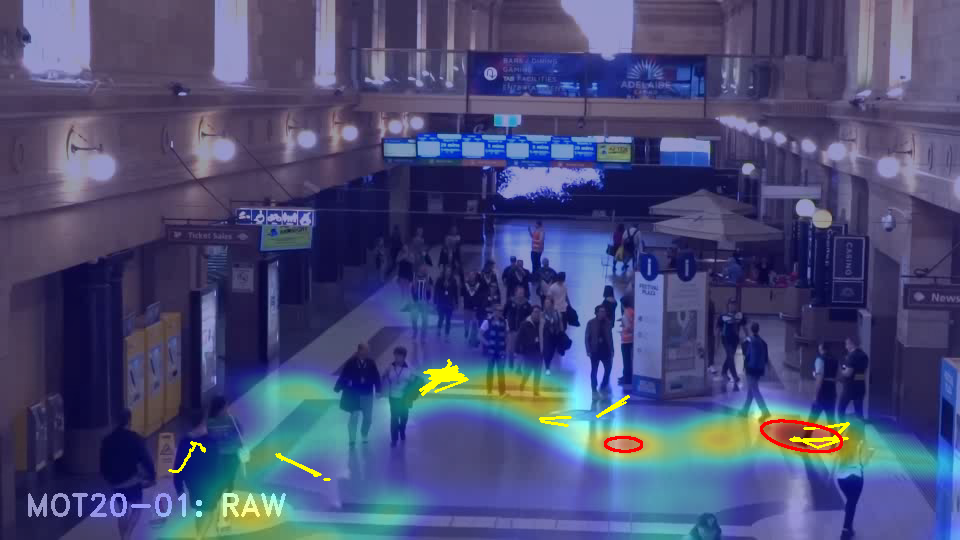

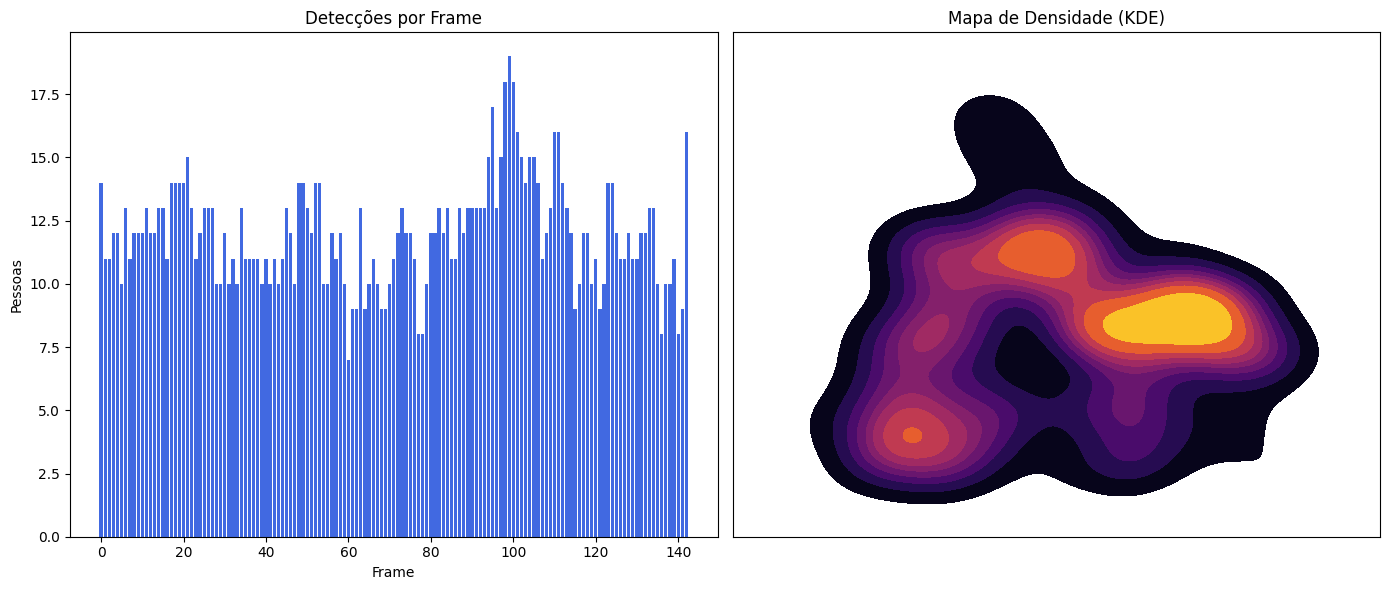


--- Resumo ---
Frames processados: 143
IDs rastreados √∫nicos: 204
M√©dia por frame: 11.98
-------------------


In [ ]:
# ==================================================================================================
# FASE 2: RASTREAMENTO + AN√ÅLISE VISUAL MELHORADA (INSPIRED BY: https://youtu.be/wPbC3BtQLqI)
# OBJETIVO: Criar uma vers√£o intermedi√°ria com rastreamento leve, mapa de calor acumulado e
# visualiza√ß√µes com destaque para trajet√≥rias e zonas de calor
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALA√á√ïES E IMPORTA√á√ïES
# --------------------------------------------------------------------------------------------------
!pip install ultralytics tqdm filterpy matplotlib seaborn -q

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque

%matplotlib inline

# --------------------------------------------------------------------------------------------------
# 2. CONFIGURA√á√ïES
# --------------------------------------------------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/'
VIDEO_PATH = os.path.join(BASE_DIR, 'videos/MOT20-01-raw.webm')
RESULTS_PATH = os.path.join(BASE_DIR, 'resultados/')

MODEL_NAME = 'yolov8n.pt'
CONF_THRESHOLD = 0.4
FRAME_SKIP = 2

HEAT_POINT_INTENSITY = 5
HEATMAP_ALPHA = 0.4
COLOR_MAP = cv2.COLORMAP_JET

# Tamanho do kernel proporcional ao v√≠deo
GAUSSIAN_SCALE = 0.15

# --------------------------------------------------------------------------------------------------
# 3. TRACKER SIMPLES (SORT-LIKE)
# --------------------------------------------------------------------------------------------------
class Track:
    def __init__(self, track_id, position):
        self.id = track_id
        self.positions = deque([position], maxlen=30)

    def update(self, position):
        self.positions.append(position)

class Tracker:
    def __init__(self):
        self.next_id = 0
        self.tracks = []

    def update(self, detections):
        updated = []
        for det in detections:
            matched = False
            for track in self.tracks:
                if np.linalg.norm(np.array(det) - np.array(track.positions[-1])) < 50:
                    track.update(det)
                    updated.append(track)
                    matched = True
                    break
            if not matched:
                new_track = Track(self.next_id, det)
                updated.append(new_track)
                self.next_id += 1
        self.tracks = updated
        return self.tracks

# --------------------------------------------------------------------------------------------------
# 4. FUN√á√ÉO PRINCIPAL
# --------------------------------------------------------------------------------------------------
def generate_heatmap_and_tracking():
    os.makedirs(RESULTS_PATH, exist_ok=True)
    model = YOLO(MODEL_NAME)

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("Erro ao abrir o v√≠deo.")
        return

    fw, fh = int(cap.get(3)), int(cap.get(4))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    kernel_size = (int(fw * GAUSSIAN_SCALE), int(fh * GAUSSIAN_SCALE))
    kernel_size = tuple(k+1 if k % 2 == 0 else k for k in kernel_size)

    heatmap = np.zeros((fh, fw), dtype=np.float32)
    tracker = Tracker()
    all_coords, detections_per_frame = [], []
    unique_ids = set()
    bg_frame, captured = None, False

    with tqdm(total=total_frames, desc="Processando") as bar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            bar.update(1)
            if not captured:
                bg_frame = frame.copy()
                captured = True

            if bar.n % (FRAME_SKIP + 1) != 0:
                continue

            results = model(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)
            centers = []

            for r in results:
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cx, cy = int((x1 + x2) / 2), int(y2)
                    centers.append((cx, cy))

            tracks = tracker.update(centers)
            detections_per_frame.append(len(tracks))

            for track in tracks:
                cx, cy = track.positions[-1]
                if 0 <= cx < fw and 0 <= cy < fh:
                    heatmap[cy, cx] += HEAT_POINT_INTENSITY
                    all_coords.append((cx, cy))
                    unique_ids.add(track.id)

    cap.release()

    heatmap = cv2.GaussianBlur(heatmap, kernel_size, 0)
    norm_heat = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    color_map = cv2.applyColorMap(norm_heat, COLOR_MAP)
    final_img = cv2.addWeighted(bg_frame, 1 - HEATMAP_ALPHA, color_map, HEATMAP_ALPHA, 0)

    # Trajet√≥rias
    for track in tracker.tracks:
        if len(track.positions) > 1:
            pts = np.array(track.positions, dtype=np.int32)
            cv2.polylines(final_img, [pts], False, (0, 255, 255), thickness=2)

    # Contornos
    _, th = cv2.threshold(norm_heat, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(final_img, contours, -1, (0, 0, 255), 2)

    output_path = os.path.join(RESULTS_PATH, 'fase2_heatmap_tracking.png')
    cv2.imwrite(output_path, final_img)
    print(f"\n‚úÖ Mapa de calor com trajet√≥rias salvo em: {output_path}")
    cv2_imshow(cv2.resize(final_img, (960, 540)))

    # ANALISES
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(detections_per_frame)), detections_per_frame, color='royalblue')
    plt.title("Detec√ß√µes por Frame")
    plt.xlabel("Frame")
    plt.ylabel("Pessoas")

    plt.subplot(1, 2, 2)
    if all_coords:
        x, y = zip(*all_coords)
        sns.kdeplot(x=x, y=y, cmap="inferno", fill=True, bw_adjust=1)
        plt.gca().invert_yaxis()
        plt.xticks([])
        plt.yticks([])
        plt.title("Mapa de Densidade (KDE)")

    plt.tight_layout()
    plt.show()

    print("\n--- Resumo ---")
    print(f"Frames processados: {len(detections_per_frame)}")
    print(f"IDs rastreados √∫nicos: {len(unique_ids)}")
    print(f"M√©dia por frame: {np.mean(detections_per_frame):.2f}")
    print("-------------------")

# --------------------------------------------------------------------------------------------------
# 5. EXECU√á√ÉO
# --------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    generate_heatmap_and_tracking()


Processando: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2782/2782 [02:54<00:00, 15.93it/s]



‚úÖ Mapa de calor com trajet√≥rias salvo em: /content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/resultados/fase2_heatmap_tracking.png


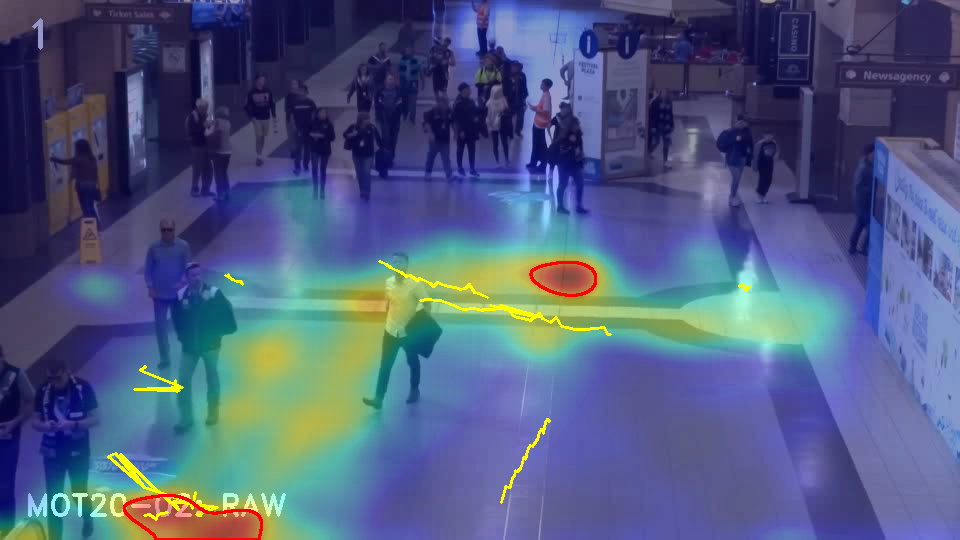

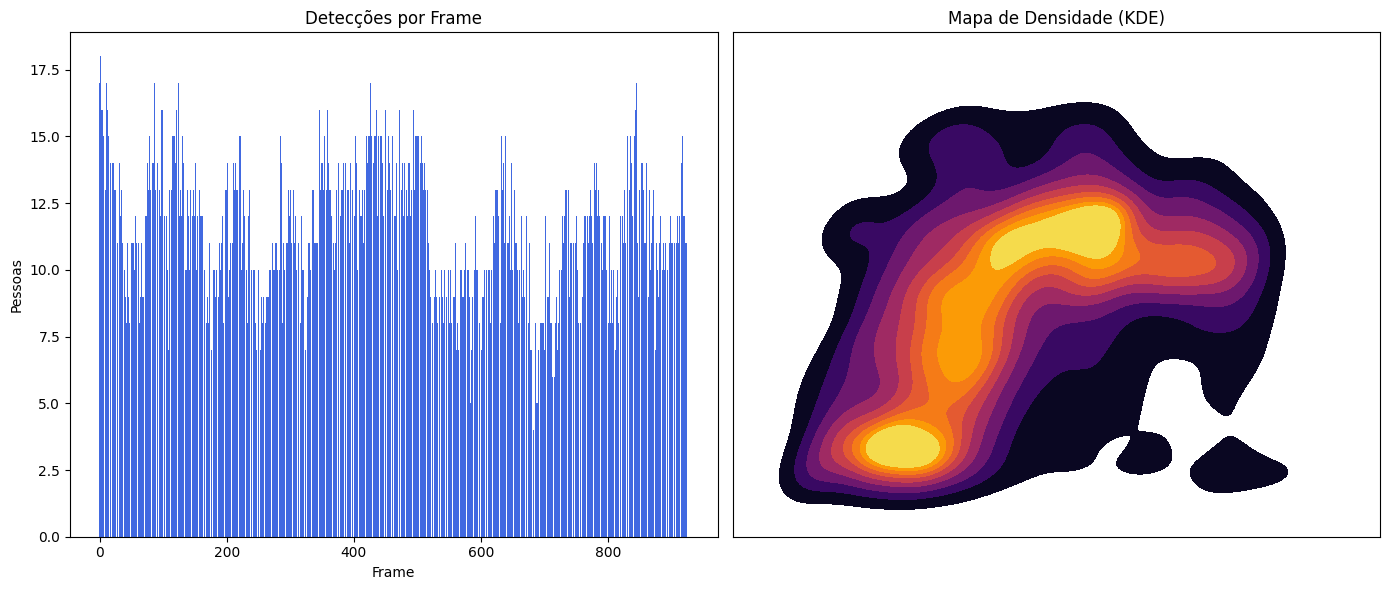


--- Resumo ---
Frames processados: 927
IDs rastreados √∫nicos: 1234
M√©dia por frame: 11.37
-------------------


In [ ]:
# ==================================================================================================
# FASE 2: RASTREAMENTO + AN√ÅLISE VISUAL MELHORADA (INSPIRED BY: https://youtu.be/wPbC3BtQLqI)
# OBJETIVO: Criar uma vers√£o intermedi√°ria com rastreamento leve, mapa de calor acumulado e
# visualiza√ß√µes com destaque para trajet√≥rias e zonas de calor
# ==================================================================================================

# --------------------------------------------------------------------------------------------------
# 1. INSTALA√á√ïES E IMPORTA√á√ïES
# --------------------------------------------------------------------------------------------------
!pip install ultralytics tqdm filterpy matplotlib seaborn -q

import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque

%matplotlib inline

# --------------------------------------------------------------------------------------------------
# 2. CONFIGURA√á√ïES
# --------------------------------------------------------------------------------------------------
BASE_DIR = '/content/drive/MyDrive/visao_computacional/gerador-mapas-calor/C√≥digo/'
VIDEO_PATH = os.path.join(BASE_DIR, 'videos/meuvideo.webm')
RESULTS_PATH = os.path.join(BASE_DIR, 'resultados/')

MODEL_NAME = 'yolo11n.pt'
CONF_THRESHOLD = 0.4
FRAME_SKIP = 2

HEAT_POINT_INTENSITY = 5
HEATMAP_ALPHA = 0.4
COLOR_MAP = cv2.COLORMAP_JET

# Tamanho do kernel proporcional ao v√≠deo
GAUSSIAN_SCALE = 0.15

# --------------------------------------------------------------------------------------------------
# 3. TRACKER SIMPLES (SORT-LIKE)
# --------------------------------------------------------------------------------------------------
class Track:
    def __init__(self, track_id, position):
        self.id = track_id
        self.positions = deque([position], maxlen=30)

    def update(self, position):
        self.positions.append(position)

class Tracker:
    def __init__(self):
        self.next_id = 0
        self.tracks = []

    def update(self, detections):
        updated = []
        for det in detections:
            matched = False
            for track in self.tracks:
                if np.linalg.norm(np.array(det) - np.array(track.positions[-1])) < 50:
                    track.update(det)
                    updated.append(track)
                    matched = True
                    break
            if not matched:
                new_track = Track(self.next_id, det)
                updated.append(new_track)
                self.next_id += 1
        self.tracks = updated
        return self.tracks

# --------------------------------------------------------------------------------------------------
# 4. FUN√á√ÉO PRINCIPAL
# --------------------------------------------------------------------------------------------------
def generate_heatmap_and_tracking():
    os.makedirs(RESULTS_PATH, exist_ok=True)
    model = YOLO(MODEL_NAME)

    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("Erro ao abrir o v√≠deo.")
        return

    fw, fh = int(cap.get(3)), int(cap.get(4))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    kernel_size = (int(fw * GAUSSIAN_SCALE), int(fh * GAUSSIAN_SCALE))
    kernel_size = tuple(k+1 if k % 2 == 0 else k for k in kernel_size)

    heatmap = np.zeros((fh, fw), dtype=np.float32)
    tracker = Tracker()
    all_coords, detections_per_frame = [], []
    unique_ids = set()
    bg_frame, captured = None, False

    with tqdm(total=total_frames, desc="Processando") as bar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            bar.update(1)
            if not captured:
                bg_frame = frame.copy()
                captured = True

            if bar.n % (FRAME_SKIP + 1) != 0:
                continue

            results = model(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)
            centers = []

            for r in results:
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cx, cy = int((x1 + x2) / 2), int(y2)
                    centers.append((cx, cy))

            tracks = tracker.update(centers)
            detections_per_frame.append(len(tracks))

            for track in tracks:
                cx, cy = track.positions[-1]
                if 0 <= cx < fw and 0 <= cy < fh:
                    heatmap[cy, cx] += HEAT_POINT_INTENSITY
                    all_coords.append((cx, cy))
                    unique_ids.add(track.id)

    cap.release()

    heatmap = cv2.GaussianBlur(heatmap, kernel_size, 0)
    norm_heat = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    color_map = cv2.applyColorMap(norm_heat, COLOR_MAP)
    final_img = cv2.addWeighted(bg_frame, 1 - HEATMAP_ALPHA, color_map, HEATMAP_ALPHA, 0)

    # Trajet√≥rias
    for track in tracker.tracks:
        if len(track.positions) > 1:
            pts = np.array(track.positions, dtype=np.int32)
            cv2.polylines(final_img, [pts], False, (0, 255, 255), thickness=2)

    # Contornos
    _, th = cv2.threshold(norm_heat, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(final_img, contours, -1, (0, 0, 255), 2)

    output_path = os.path.join(RESULTS_PATH, 'fase2_heatmap_tracking.png')
    cv2.imwrite(output_path, final_img)
    print(f"\n‚úÖ Mapa de calor com trajet√≥rias salvo em: {output_path}")
    cv2_imshow(cv2.resize(final_img, (960, 540)))

    # ANALISES
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(detections_per_frame)), detections_per_frame, color='royalblue')
    plt.title("Detec√ß√µes por Frame")
    plt.xlabel("Frame")
    plt.ylabel("Pessoas")

    plt.subplot(1, 2, 2)
    if all_coords:
        x, y = zip(*all_coords)
        sns.kdeplot(x=x, y=y, cmap="inferno", fill=True, bw_adjust=1)
        plt.gca().invert_yaxis()
        plt.xticks([])
        plt.yticks([])
        plt.title("Mapa de Densidade (KDE)")

    plt.tight_layout()
    plt.show()

    print("\n--- Resumo ---")
    print(f"Frames processados: {len(detections_per_frame)}")
    print(f"IDs rastreados √∫nicos: {len(unique_ids)}")
    print(f"M√©dia por frame: {np.mean(detections_per_frame):.2f}")
    print("-------------------")

# --------------------------------------------------------------------------------------------------
# 5. EXECU√á√ÉO
# --------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    generate_heatmap_and_tracking()
